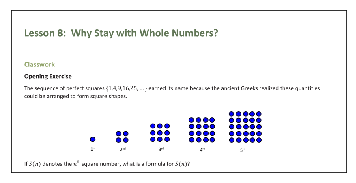

In [1]:
from wand.image import Image
from IPython.utils import io

raw = cv2.imread('../data/EngageNY/Algebra1-m03-b-l08.png');

# the following with... statement is a way to keep matplotlib commands from chattering output
# (from https://stackoverflow.com/questions/23692950/how-do-you-suppress-output-in-ipython-notebook)
with io.capture_output() as captured:
    # just render the top 400 pixel-rows of the image
    plt.imshow(cv2.cvtColor(raw[0:400,:], cv2.COLOR_BGR2RGB))
    plt.xticks([])
    plt.yticks([])
 
plt.show()

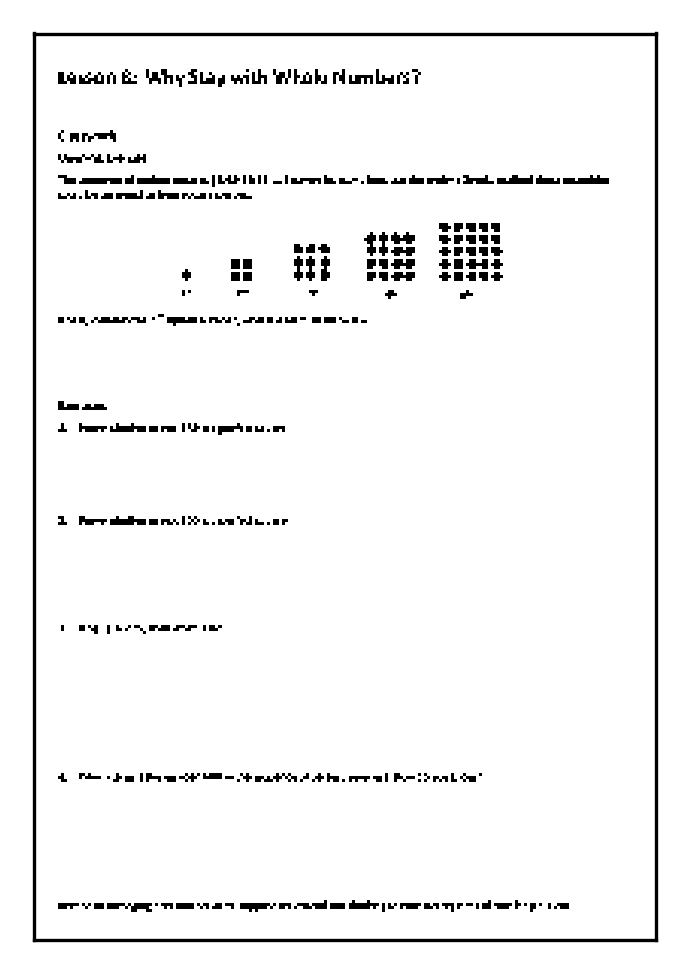

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import modules.pdfutil as pdfutil

mpl.rcParams['figure.dpi']= 300 # sets a target resolution for the rendering of the image figure

downsampled = cv2.resize(raw, None, fx=0.25,fy=0.25)
gray = cv2.cvtColor(downsampled, cv2.COLOR_BGR2GRAY)
# gray = np.uint8(gray16 / 256)

thresh = cv2.adaptiveThreshold(gray, 1, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 5, 10)

with io.capture_output() as captured:
    # just render the top 300 pixel-rows of the grayscale+threshold image
    plt.imshow(thresh[0:300,:], cmap='gray' , interpolation='none')
    plt.xticks([])
    plt.yticks([])
    
plt.show()

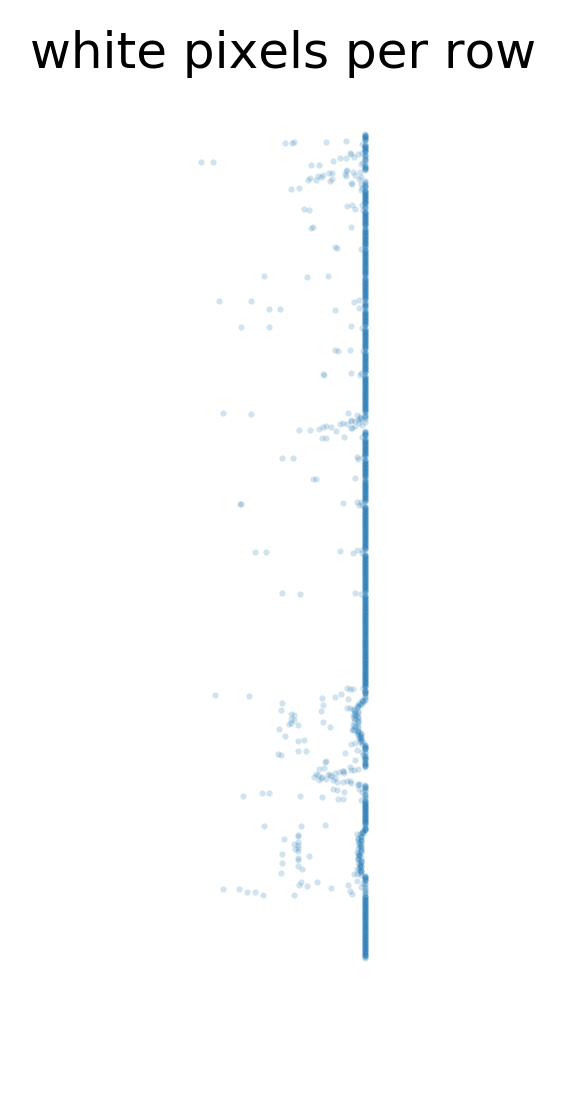

In [3]:
#count the number of (thresholded-to) white pixels in each row
row_counts = cv2.reduce(thresh, 1, cv2.REDUCE_SUM, dtype=cv2.CV_32SC1).flatten()

#plot the white pixel counts
with io.capture_output() as captured:
    plt.scatter(row_counts, range(0,len(row_counts)), marker='.', alpha=0.2, s=1)
    plt.gca().set_aspect(0.5)
    plt.gca().invert_yaxis()
    plt.gca().axis('off')
    plt.title('white pixels per row')
    
plt.show()

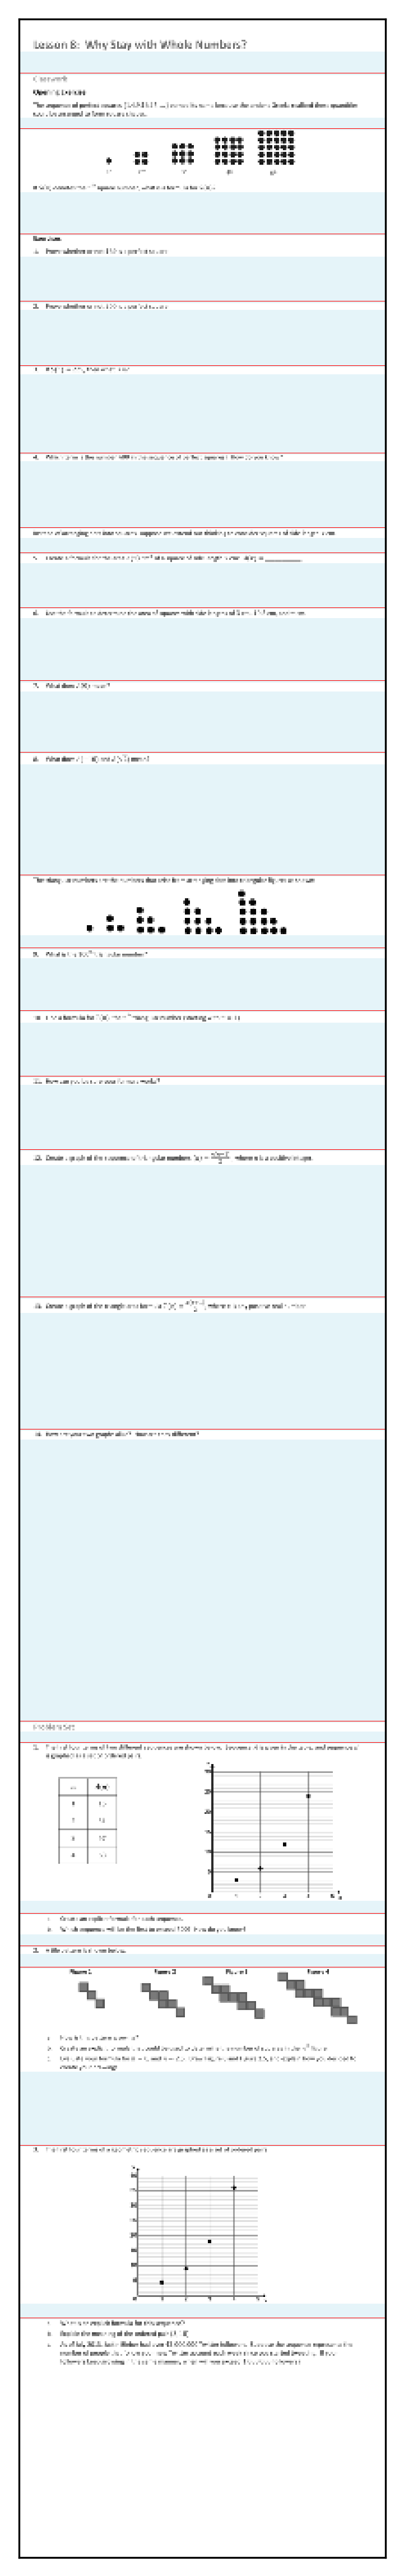

In [4]:
from itertools import groupby
from statistics import median
import matplotlib.patches as patches

height,width = gray.shape;

# white_rows is a binary vector of length height. white_rows[i]=1 if and only if the i'th row
# in the thresholded image is all white pixels
white_rows = np.where(row_counts==max(row_counts), 1, 0)

# from white_rows we build the array white_blocks that contains arrays of the form [start,end]
# with the start and end rows of all-white blocks of rows... i.e. bound on vertical whitespace
white_blocks = []
pos = 0
for k,g in groupby(white_rows):
   start = pos
   end = pos + len(list(g))
   is_margin = start==0 or end==height
   if k==1 and not is_margin: 
       white_blocks.append([start,end-1])
   pos = end

median_size = median([b[1]-b[0] for b in white_blocks])

min_block_size = max(median_size//5, 5)

# throw out small blocks of whitespace
white_blocks = [b for b in white_blocks if (b[1]-b[0]>=min_block_size)]

# alternate array of only above-median height blocks of whitespace
big_blocks = [b for b in white_blocks if (b[1]-b[0]>=median_size)]

only_big = (len(white_blocks) > 5)
blocks = big_blocks if only_big else white_blocks

# place segmentation breaks within the selected whitespace blocks... near the bottom of each
breaks = [b[1] - min(median_size//5, (b[1]-b[0])//2)  for b in blocks]

# render an image showing what the algorithm did:
fig1 = plt.figure(figsize = (8.5,20))
ax = fig1.add_subplot(1,1,1)

with io.capture_output() as captured:
    ax.imshow(gray, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

    #highlight the detected vertical whitespace blocks in light blue
    for b in blocks:
        rect = patches.Rectangle((0,b[0]),width, b[1]-b[0],linewidth=1,
                                 edgecolor='none',facecolor=(0.0,0.6,0.8,0.1))
        ax.add_patch(rect)

    #highlight the cut lines in red:
    for b in breaks:
        rect = patches.Rectangle((0,b),width, 0,linewidth=0.25,edgecolor='r',facecolor='none')
        ax.add_patch(rect)




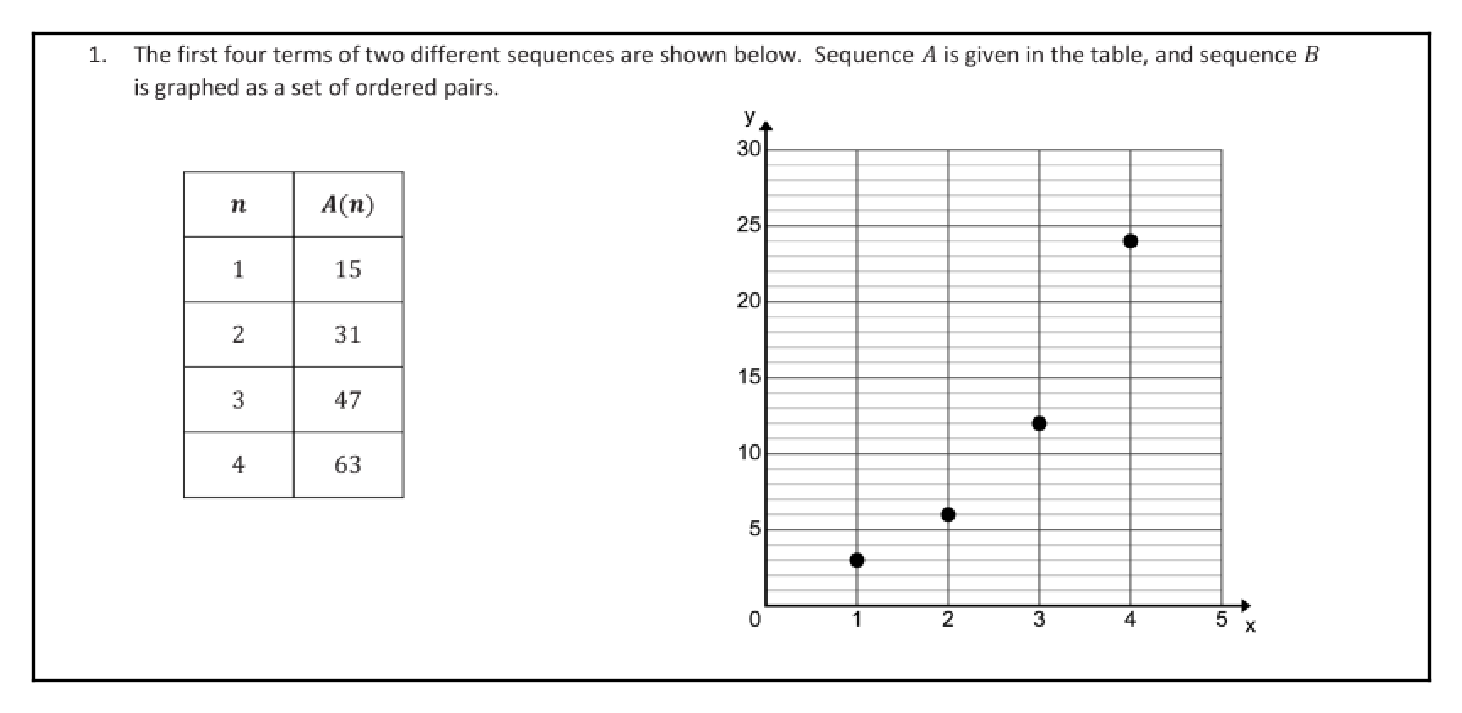

In [5]:
# using the segmentation cut lines, take a bunch of subimages from the original (raw) image array
subimage_bounds = []
pos = 0
for b in breaks:
    subimage_bounds.append([pos, b])
    pos = b
subimage_bounds.append([pos,height])

# the subimages array will contain an array of len(breaks)+1 non-overlapping images taken from raw[]
# (the raw image was downsampled by 4x in the processing that found the cut lines, hence the 4* below.)
subimages = [ raw[4*int(b[0]):4*int(b[1])-1] for b in subimage_bounds ]

subimage_to_show = 20
with io.capture_output() as captured:
    plt.imshow(cv2.cvtColor(subimages[subimage_to_show], cv2.COLOR_BGR2RGB))
    plt.xticks([])
    plt.yticks([])
 
plt.show()
